# Emotions Classifier using BERT

* Authors: Nathan DANIS & Romain CAUSSIGNAC
* Class: I2 - BDML 1

### Vérification de l'environnement d'exécution Colab

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  8 16:47:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             66W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('The runtime has {:.1f} GB of available RAM\n'.format(ram_gb))

The runtime has 89.6 GB of available RAM



In [ ]:
!pip install -U datasets

In [ ]:
# import os
# os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import tqdm as notebook_tqdm

### Chargement du Dataset GoEmotions

In [ ]:
def load_goemotions_dataset():
    try:
        dataset = load_dataset("google-research-datasets/go_emotions", "raw")
        df = dataset['train'].to_pandas()
        return df
    except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        return None

In [ ]:
df = load_goemotions_dataset()

## Nettoyage du Dataset

In [ ]:
!pip install emoji

In [ ]:
import re
import emoji

In [ ]:
EMOJIS = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
EMOJI_PATTERN = re.compile('|'.join(re.escape(u) for u in EMOJIS))
MULTI_EMOJI_PATTERN = re.compile(r"({})\1+".format(EMOJI_PATTERN.pattern))
REPEATED_CHAR_PATTERN = re.compile(r'(.)\1{2,}')

emoticon_dict = {
    ':)': '<smile_face>',
    ':-)': '<smile_face>',
    ':(': '<sad_face>',
    ':-(': '<sad_face>',
    ':D': '<big_smile>',
    ';)': '<wink>',
    ':-P': '<tongue_out>',
    ':/': '<unsure_face>',
    '<3': '<heart>',
    '¯_(ツ)_/¯': '<shrug>',
}

In [ ]:
def majority_vote(x):
    return (x.sum() >= len(x) / 2).astype(int)

def aggregate_rows(df, aggregation_function, emotions):
    aggregations = {col: aggregation_function for col in emotions}
    df_processed = df.groupby(['text']).agg(aggregations).reset_index()
    mask = df_processed[emotions].sum(axis=1) > 0
    return df_processed[mask].reset_index(drop=True)

def preprocess_text(text):
    # Replace sequences of the same emoji with a single emoji
    text = MULTI_EMOJI_PATTERN.sub(r"\1", text)

    # Limit repeated characters to three repetitions
    text = REPEATED_CHAR_PATTERN.sub(r'\1\1\1', text)

    # Replace user mentions with a special token
    text = re.sub(r'u/\w+', '<user>', text)

    # Replace prices
    text = re.sub(r'\$\d{1,3}(,\d{3})*(\.\d+)?', '<PRICE>', text)

    # Replace times
    text = re.sub(r'\b\d{1,2}:\d{2}(:\d{2})?\b', '<TIME>', text)

    # Replace numbers except 1 or 2 digit integers
    text = re.sub(r'\d{1,3}(,\d{3})*(\.\d+)?|\d+(\.\d+)?',
                  lambda m: '<NUM>' if len(m.group(0))>2 else m.group(0), text)

    for emoticon, name in emoticon_dict.items():
        text = text.replace(emoticon, name)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
text_col = 'text'
emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
                'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
                'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
                'relief', 'remorse', 'sadness', 'surprise', 'neutral']

emotion_cols_no_neutral = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
                'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
                'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
                'relief', 'remorse', 'sadness', 'surprise']

In [ ]:
print(len(df))

211225


### Supression des lignes avec l'émotion neutre uniquement

In [ ]:
mask = df['neutral'] == 0
df = df[mask].copy()
print(len(df))

155927


In [ ]:
df = df[[text_col] + emotion_cols_no_neutral].copy()
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"He isn't as big, but he's still quite popular....",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


On combine les lignes en fonction de l'émotion dominante, car les textes ont été labellisés par des personnes différentes, donc ils apparaissent plusieurs fois, et parfois avec des émotions différentes

In [ ]:
mask = df[emotion_cols_no_neutral].sum(axis=1) > 0
df_filtered = df[mask].copy()
df_aggregate = aggregate_rows(df_filtered, majority_vote, emotion_cols_no_neutral)
print(len(df_aggregate))

46302


In [ ]:
emotions_per_row = df_aggregate[emotion_cols_no_neutral].sum(axis=1)
one_emotion = emotions_per_row == 1

print(f"Lignes avec 1 émotion: {one_emotion.sum()} / {len(df_aggregate)} ({(one_emotion.sum() / len(df_aggregate)) * 100:.1f}%)")
df_aggregate.head()

Lignes avec 1 émotion: 35683 / 46302 (77.1%)


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,And not all children's hospitals need the sam...,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


### On applique les RegEx pour que BERT puisse mieux saisir le sens

In [ ]:
df_clean = df_aggregate.copy()
df_clean[text_col] = df_clean[text_col].apply(preprocess_text)

## Dataframe avec nos 27 émotions

In [ ]:
df_27_emotions = df_clean.copy()

## On passe de 27 à 6 émotions
Les 6 émotions d'Ekman constituent un standard scientifique robuste qui évite les ambiguïtés d'annotation et optimise les performances de classification sur texte.

In [ ]:
emotion_cols_ekman = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
df_6_emotions = df_clean[['text'] + emotion_cols_ekman].copy()

In [ ]:
# Vu qu'on a supprimé beaucoup de colonnes, certaines lignes n'ont plus d'émotions = 1 donc on les supprime
mask = df_6_emotions[emotion_cols_ekman].sum(axis=1) > 0
df_6_emotions = df_6_emotions[mask].copy()
print(len(df_6_emotions))

10049


## On passe de 27 à 2 émotions
Positif vs Negatif (ici on se rebase sur notre dataframe `df_clean` qui contient toutes les émotions)

In [ ]:
def create_binary_labels(df, emotion_cols):
    groups = {
        'positive': ['admiration', 'amusement', 'approval', 'excitement', 'gratitude',
                    'joy', 'love', 'optimism', 'pride', 'relief', 'caring', 'curiosity'],
        'negative': ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
                    'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']
    }

    df_binary = df.copy()
    for group_name, emotions in groups.items():
        df_binary[group_name] = df[[e for e in emotions if e in emotion_cols]].max(axis=1)

    return df_binary[['text'] + list(groups.keys())]

In [ ]:
emotion_cols_binary = ['positive', 'negative']
df_2_emotions = create_binary_labels(df_clean, emotion_cols_no_neutral)

In [ ]:
print(len(df_2_emotions))
df_2_emotions.head()

46302


,text,positive,negative
0,"""If you don't wear BROWN AND ORANGE...YOU DON'...",0,1
1,"""What do Scottish people look like?"" How I wou...",1,0
2,"### A surprise, to be sure, but a welcome one",0,0
3,>sexuality shouldn’t be a grouping category It...,1,1
4,And not all children's hospitals need the same...,1,0


## Finetuning BERT avec chaque dataset (27 émotions, 6 émotions, 2 émotions)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
from datasets import Dataset
torch.manual_seed(42)

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA


In [ ]:
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 8
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    y_pred_probs = torch.sigmoid(torch.tensor(predictions)).numpy()
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Seuil à 0.5
    y_true = labels.astype(int)

    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_samples = f1_score(y_true, y_pred, average='samples')  # Spécifique au multi-label

    exact_match = np.mean(np.all(y_true == y_pred, axis=1))

    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_samples': f1_samples,
        'exact_match': exact_match
    }

def compute_metrics_detailed(eval_pred, label_names):
    predictions, labels = eval_pred

    y_pred_probs = torch.sigmoid(torch.tensor(predictions)).numpy()
    y_pred = (y_pred_probs >= 0.5).astype(int)
    y_true = labels.astype(int)

    from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

    metrics = {
        'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_samples': f1_score(y_true, y_pred, average='samples', zero_division=0),
        'precision_micro': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_micro': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'exact_match': np.mean(np.all(y_true == y_pred, axis=1))
    }

    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)

    for i, label in enumerate(label_names):
        if i < len(f1_per_class):
            metrics[f'f1_{label}'] = f1_per_class[i]
            metrics[f'precision_{label}'] = precision_per_class[i]
            metrics[f'recall_{label}'] = recall_per_class[i]

    return metrics

In [ ]:
# Fonction de sauvegarde et de téléchargement du modèle
import os
import shutil
from google.colab import files

def save_and_download_model(trainer, tokenizer, model_name="bert_emotions_final"):
    print("💾 Sauvegarde du modèle...")

    # Sauvegarde locale
    trainer.save_model(f"./{model_name}")
    tokenizer.save_pretrained(f"./{model_name}")

    # Création d'une archive ZIP
    print("📦 Création de l'archive...")
    shutil.make_archive(model_name, "zip", f"./{model_name}")

    # Téléchargement
    print("⬇️ Téléchargement en cours...")
    files.download(f"{model_name}.zip")

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

### Entrainement sur les 27 émotions

In [ ]:
texts = df_27_emotions['text'].tolist()
y_emotions = df_27_emotions[emotion_cols_no_neutral].values

In [ ]:
model_27 = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=27,
    problem_type="multi_label_classification"
)
model_27.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### Séparation des données en train, validation et test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, y_emotions,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

In [ ]:
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Train: 29632
Validation: 7409
Test: 9261


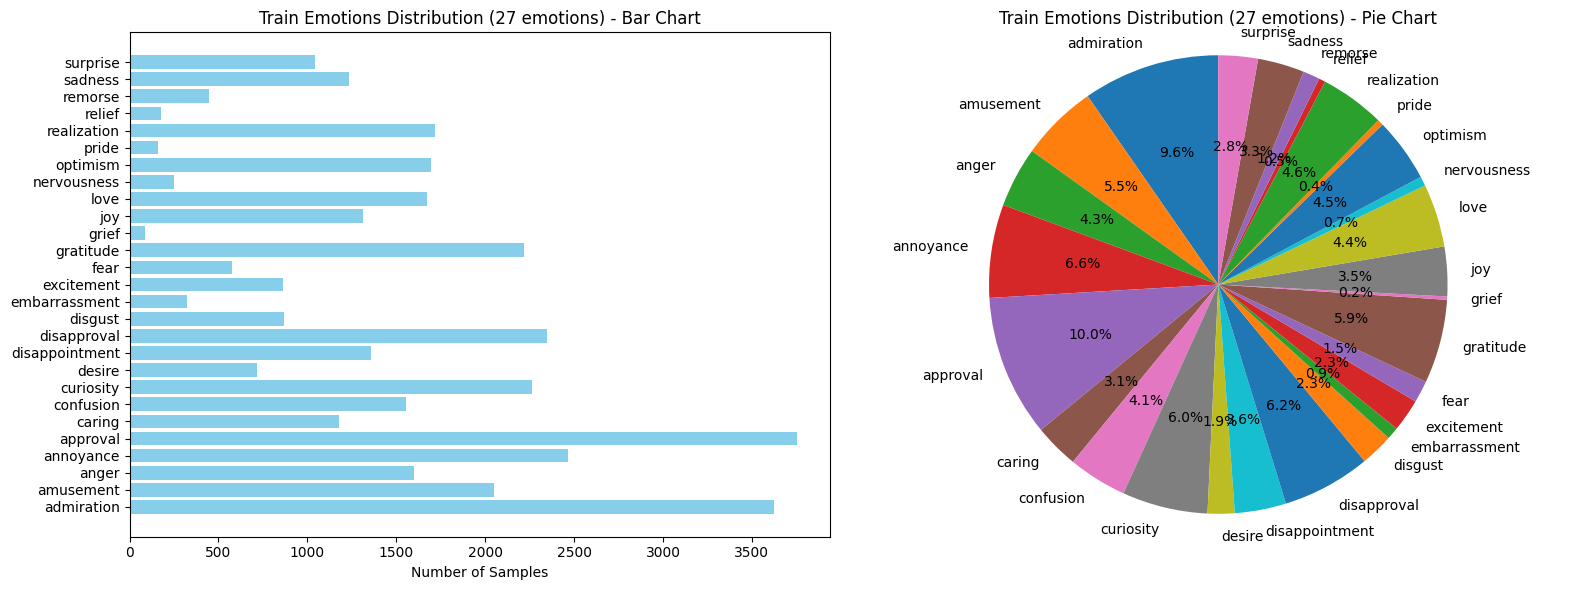

In [ ]:
def plot_emotions_distribution(y, title, emotion_labels):
    emotions_count = np.sum(y, axis=0)

    plt.figure(figsize=(16, 6))

    # Graphique en barres
    plt.subplot(1, 2, 1)
    plt.barh(emotion_labels, emotions_count, color='skyblue')
    plt.xlabel('Number of Samples')
    plt.title(f'{title} - Bar Chart')

    # Camembert
    plt.subplot(1, 2, 2)
    plt.pie(emotions_count,
            labels=emotion_labels,
            autopct='%1.1f%%',
            startangle=90)
    plt.title(f'{title} - Pie Chart')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()


plot_emotions_distribution(y_train, "Train Emotions Distribution (27 emotions)", emotion_cols_no_neutral)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

In [ ]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(y_train, dtype=torch.float)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': torch.tensor(y_val, dtype=torch.float)
})

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    run_name='bert-emotions',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,

    fp16=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,

    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    load_best_model_at_end=True,
    report_to=[]
)

In [ ]:
trainer_27 = Trainer(
    model=model_27,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda eval_pred: compute_metrics_detailed(eval_pred, emotion_cols_no_neutral)
)

In [ ]:
# FINE-TUNING
print("🚀 Début du fine-tuning...")
trainer_27.train()
print("✅ Fine-tuning terminé!")

🚀 Début du fine-tuning...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Samples,Precision Micro,Precision Macro,Recall Micro,Recall Macro,Exact Match,F1 Admiration,Precision Admiration,Recall Admiration,F1 Amusement,Precision Amusement,Recall Amusement,F1 Anger,Precision Anger,Recall Anger,F1 Annoyance,Precision Annoyance,Recall Annoyance,F1 Approval,Precision Approval,Recall Approval,F1 Caring,Precision Caring,Recall Caring,F1 Confusion,Precision Confusion,Recall Confusion,F1 Curiosity,Precision Curiosity,Recall Curiosity,F1 Desire,Precision Desire,Recall Desire,F1 Disappointment,Precision Disappointment,Recall Disappointment,F1 Disapproval,Precision Disapproval,Recall Disapproval,F1 Disgust,Precision Disgust,Recall Disgust,F1 Embarrassment,Precision Embarrassment,Recall Embarrassment,F1 Excitement,Precision Excitement,Recall Excitement,F1 Fear,Precision Fear,Recall Fear,F1 Gratitude,Precision Gratitude,Recall Gratitude,F1 Grief,Precision Grief,Recall Grief,F1 Joy,Precision Joy,Recall Joy,F1 Love,Precision Love,Recall Love,F1 Nervousness,Precision Nervousness,Recall Nervousness,F1 Optimism,Precision Optimism,Recall Optimism,F1 Pride,Precision Pride,Recall Pride,F1 Realization,Precision Realization,Recall Realization,F1 Relief,Precision Relief,Recall Relief,F1 Remorse,Precision Remorse,Recall Remorse,F1 Sadness,Precision Sadness,Recall Sadness,F1 Surprise,Precision Surprise,Recall Surprise
1,0.112400,0.111736,0.478168,0.284273,0.404164,0.400846,0.735030,0.440264,0.354341,0.243913,0.325280,0.719424,0.772201,0.673401,0.794466,0.822086,0.768642,0.483453,0.591549,0.408759,0.000000,0.000000,0.000000,0.329393,0.645062,0.221164,0.220238,0.672727,0.131673,0.214953,0.836364,0.123324,0.633663,0.608997,0.660413,0.239583,0.741935,0.142857,0.000000,0.000000,0.000000,0.461860,0.669697,0.352472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039062,1.000000,0.019920,0.000000,0.000000,0.000000,0.875240,0.892368,0.858757,0.000000,0.000000,0.000000,0.445808,0.694268,0.328313,0.831285,0.803456,0.861111,0.000000,0.000000,0.000000,0.500745,0.672000,0.399050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.443396,0.758065,0.313333,0.442786,0.706349,0.322464
2,0.094500,0.105628,0.521828,0.378670,0.474979,0.460966,0.726912,0.566353,0.407000,0.316769,0.375489,0.727380,0.763255,0.694725,0.791296,0.819672,0.764818,0.492260,0.676596,0.386861,0.176471,0.584746,0.103916,0.408309,0.631929,0.301587,0.440980,0.589286,0.352313,0.373281,0.698529,0.254692,0.643939,0.650096,0.637899,0.406504,0.588235,0.310559,0.043011,0.615385,0.022284,0.431203,0.672297,0.317384,0.191667,0.793103,0.109005,0.000000,0.000000,0.000000,0.246667,0.755102,0.147410,0.512195,0.692308,0.406452,0.897016,0.917323,0.877589,0.000000,0.000000,0.000000,0.494424,0.645631,0.400602,0.823256,0.827103,0.819444,0.000000,0.000000,0.000000,0.489097,0.710407,0.372922,0.000000,0.000000,0.000000,0.102128,0.585366,0.055944,0.000000,0.000000,0.000000,0.554217,0.741935,0.442308,0.483471,0.635870,0.390000,0.495327,0.697368,0.384058
3,0.081600,0.105476,0.541821,0.424627,0.511240,0.500675,0.687023,0.570717,0.447288,0.363732,0.401674,0.725352,0.760148,0.693603,0.787575,0.827368,0.751434,0.529570,0.591592,0.479319,0.267974,0.484252,0.185241,0.438120,0.584806,0.350265,0.448000,0.511416,0.398577,0.432916,0.650538,0.324397,0.638380,0.656746,0.621013,0.463320,0.612245,0.372671,0.212190,0.559524,0.130919,0.470925,0.585308,0.393939,0.352113,0.684932,0.236967,0.295455,1.000000,0.173333,0.306748,0.666667,0.199203,0.525097,0.653846,0.438710,0.899225,0.926148,0.873823,0.000000,0.000000,0.000000,0.496324,0.636792,0.406627,0.826484,0.815315,0.837963,0.000000,0.000000,0.000000,0.486486,0.735577,0.363420,0.000000,0.000000,0.000000,0.165703,0.477778,0.100233,0.000000,0.000000,0.000000,0.680412,0.733333,0.634615,0.498039,0.604762,0.423333,0.518519,0.650273,0.431159


✅ Fine-tuning terminé!


In [ ]:
save_and_download_model(trainer_27, tokenizer, "bert_emotions_27")

💾 Sauvegarde du modèle...
📦 Création de l'archive...
⬇️ Téléchargement en cours...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_encodings = tokenizer(X_test, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(y_test, dtype=torch.float)
})

### Résultats sur les 27 émotions

In [ ]:
test_results_27 = trainer_27.evaluate(test_dataset)
print(f"F1-micro: {test_results_27['eval_f1_micro']:.4f}")
print(f"F1-macro: {test_results_27['eval_f1_macro']:.4f}")
print(f"F1-weighted: {test_results_27['eval_f1_weighted']:.4f}")

F1-micro: 0.5533
F1-macro: 0.4314
F1-weighted: 0.5223


In [ ]:
print(f"\n📊 Échantillon F1-Score par émotion:")
for emotion in emotion_cols_no_neutral:
    f1 = test_results_27.get(f'eval_f1_{emotion}', 0)
    print(f"{emotion:>10}: {f1:.4f}")


📊 Échantillon F1-Score par émotion:
admiration: 0.7355
 amusement: 0.8164
     anger: 0.4874
 annoyance: 0.2652
  approval: 0.4427
    caring: 0.4796
 confusion: 0.4432
 curiosity: 0.6629
    desire: 0.4916
disappointment: 0.1846
disapproval: 0.4618
   disgust: 0.3287
embarrassment: 0.3130
excitement: 0.2857
      fear: 0.6250
 gratitude: 0.8951
     grief: 0.0000
       joy: 0.5368
      love: 0.8049
nervousness: 0.0000
  optimism: 0.5174
     pride: 0.0000
realization: 0.1752
    relief: 0.0000
   remorse: 0.5969
   sadness: 0.5032
  surprise: 0.5959


### Entrainement sur les 6 émotions

In [ ]:
texts = df_6_emotions['text'].tolist()
y_emotions = df_6_emotions[emotion_cols_ekman].values

In [ ]:
model_6 = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=6,
    problem_type="multi_label_classification"
)
model_6.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, y_emotions,
    test_size=0.2,
    random_state=42
)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

In [ ]:
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Train: 6431
Validation: 1608
Test: 2010


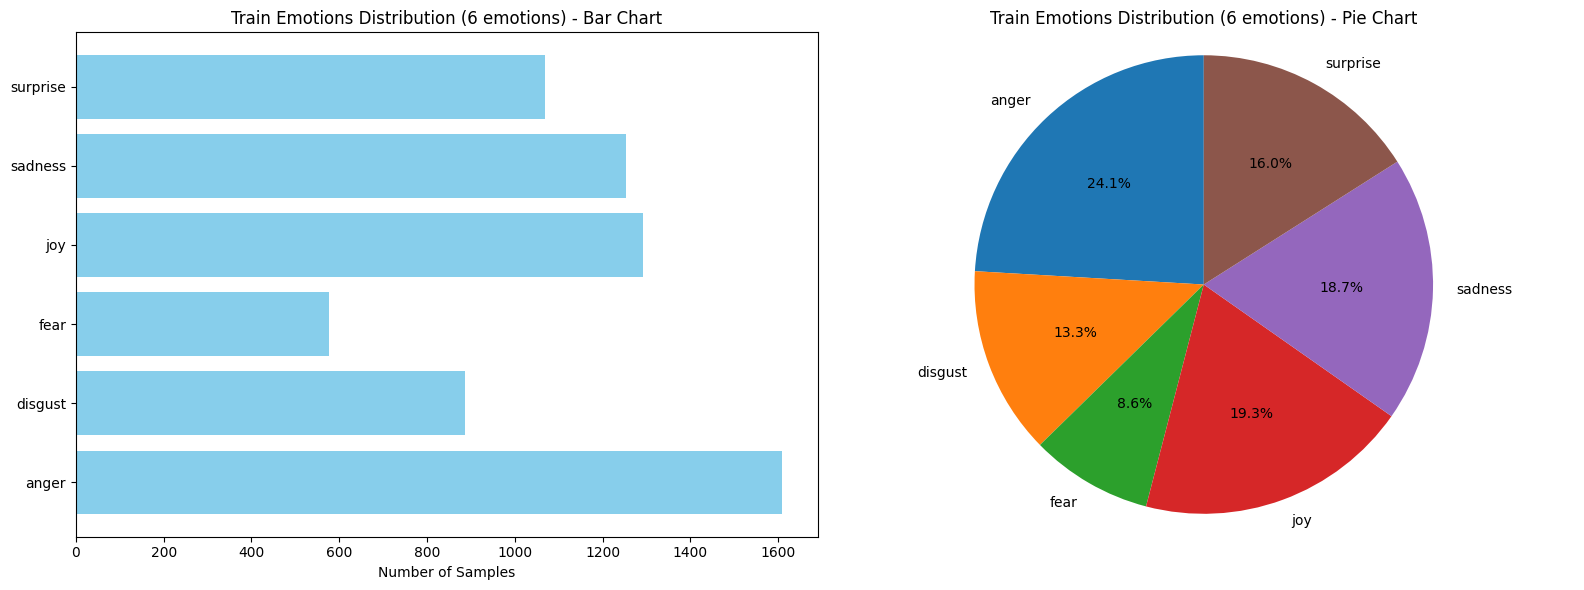

In [ ]:
plot_emotions_distribution(y_train, "Train Emotions Distribution (6 emotions)", emotion_cols_ekman)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

In [ ]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(y_train, dtype=torch.float)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': torch.tensor(y_val, dtype=torch.float)
})

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    run_name='bert-emotions',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,

    fp16=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,

    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    load_best_model_at_end=True,
    report_to=[]
)

In [ ]:
trainer_6 = Trainer(
    model=model_6,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda eval_pred: compute_metrics_detailed(eval_pred, emotion_cols_ekman)
)

In [ ]:
# FINE-TUNING
print("🚀 Début du fine-tuning...")
trainer_6.train()
print("✅ Fine-tuning terminé!")

🚀 Début du fine-tuning...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Samples,Precision Micro,Precision Macro,Recall Micro,Recall Macro,Exact Match,F1 Anger,Precision Anger,Recall Anger,F1 Disgust,Precision Disgust,Recall Disgust,F1 Fear,Precision Fear,Recall Fear,F1 Joy,Precision Joy,Recall Joy,F1 Sadness,Precision Sadness,Recall Sadness,F1 Surprise,Precision Surprise,Recall Surprise
1,0.216400,0.208288,0.772756,0.742028,0.762863,0.745170,0.819716,0.824962,0.730885,0.695211,0.726368,0.769404,0.737069,0.804706,0.489933,0.768421,0.359606,0.678700,0.839286,0.569697,0.881789,0.904918,0.859813,0.797048,0.874494,0.732203,0.835294,0.825581,0.845238
2,0.167700,0.207721,0.776299,0.756085,0.770997,0.751389,0.819398,0.814384,0.737508,0.717332,0.733209,0.768116,0.789082,0.748235,0.557994,0.767241,0.438424,0.721854,0.795620,0.660606,0.878939,0.939716,0.825545,0.791594,0.818841,0.766102,0.818011,0.775801,0.865079
3,0.118300,0.213635,0.770957,0.755011,0.768135,0.756468,0.799096,0.786731,0.744732,0.728085,0.731965,0.748166,0.778626,0.720000,0.576923,0.652174,0.517241,0.710526,0.776978,0.654545,0.878357,0.891026,0.866044,0.798635,0.804124,0.793220,0.817460,0.817460,0.817460


✅ Fine-tuning terminé!


In [ ]:
save_and_download_model(trainer_6, tokenizer, "bert_emotions_6")

💾 Sauvegarde du modèle...
📦 Création de l'archive...
⬇️ Téléchargement en cours...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_encodings = tokenizer(X_test, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(y_test, dtype=torch.float)
})

### Résultats sur les 6 émotions

In [ ]:
test_results_6 = trainer_6.evaluate(test_dataset)
print(f"F1-micro: {test_results_6['eval_f1_micro']:.4f}")
print(f"F1-macro: {test_results_6['eval_f1_macro']:.4f}")
print(f"F1-weighted: {test_results_6['eval_f1_weighted']:.4f}")

F1-micro: 0.7775
F1-macro: 0.7653
F1-weighted: 0.7752


In [ ]:
print(f"\n📊 Échantillon F1-Score par émotion:")
for emotion in emotion_cols_ekman:
    f1 = test_results_6.get(f'eval_f1_{emotion}', 0)
    print(f"{emotion:>10}: {f1:.4f}")


📊 Échantillon F1-Score par émotion:
     anger: 0.7934
   disgust: 0.6501
      fear: 0.7669
       joy: 0.8273
   sadness: 0.7872
  surprise: 0.7671


### Résultats sur les 2 émotions

In [ ]:
texts = df_2_emotions['text'].tolist()
y_emotions = df_2_emotions[emotion_cols_binary].values

In [ ]:
model_2 = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="multi_label_classification"
)
model_2.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, y_emotions,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

In [ ]:
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Train: 29632
Validation: 7409
Test: 9261


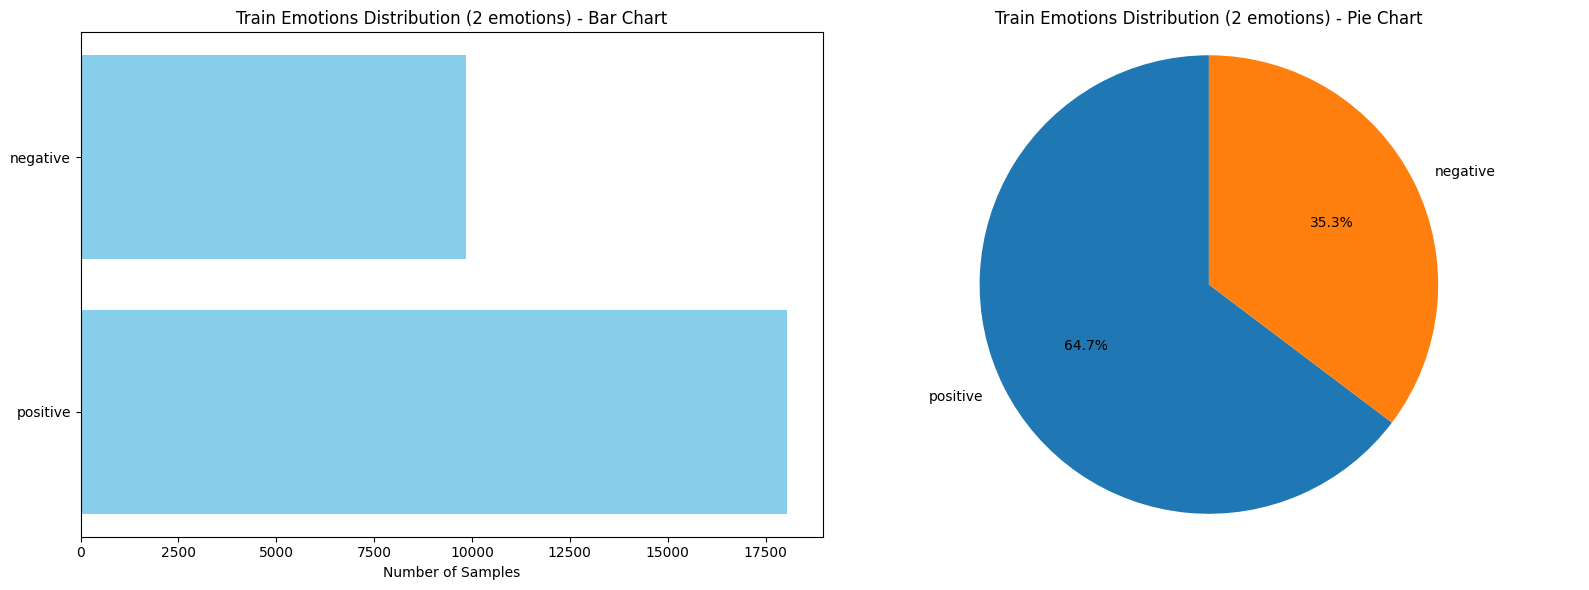

In [ ]:
plot_emotions_distribution(y_train, "Train Emotions Distribution (2 emotions)", emotion_cols_binary)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

In [ ]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(y_train, dtype=torch.float)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': torch.tensor(y_val, dtype=torch.float)
})

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    run_name='bert-emotions',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,

    fp16=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,

    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    load_best_model_at_end=True,
    report_to=[]
)

In [ ]:
trainer_2 = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda eval_pred: compute_metrics_detailed(eval_pred, emotion_cols_binary)
)

In [ ]:
# FINE-TUNING
print("🚀 Début du fine-tuning...")
trainer_2.train()
print("✅ Fine-tuning terminé!")

🚀 Début du fine-tuning...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Samples,Precision Micro,Precision Macro,Recall Micro,Recall Macro,Exact Match,F1 Positive,Precision Positive,Recall Positive,F1 Negative,Precision Negative,Recall Negative
1,0.365600,0.369608,0.837111,0.824490,0.835650,0.779412,0.825146,0.822196,0.849429,0.829335,0.770279,0.865219,0.830753,0.902669,0.783762,0.813638,0.756002
2,0.273000,0.425925,0.837345,0.824747,0.836293,0.773564,0.834848,0.828503,0.839857,0.822245,0.772439,0.866886,0.848101,0.886522,0.782609,0.808904,0.757969
3,0.187700,0.490445,0.834700,0.825238,0.834751,0.764116,0.832978,0.823233,0.836429,0.827257,0.763261,0.859960,0.859190,0.860731,0.790515,0.787276,0.793782


✅ Fine-tuning terminé!


In [ ]:
save_and_download_model(trainer_2, tokenizer, "bert_emotions_2")

💾 Sauvegarde du modèle...
📦 Création de l'archive...
⬇️ Téléchargement en cours...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_encodings = tokenizer(X_test, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(y_test, dtype=torch.float)
})

In [ ]:
test_results_2 = trainer_2.evaluate(test_dataset)
print(f"F1-micro: {test_results_2['eval_f1_micro']:.4f}")
print(f"F1-macro: {test_results_2['eval_f1_macro']:.4f}")
print(f"F1-weighted: {test_results_2['eval_f1_weighted']:.4f}")

F1-micro: 0.8327
F1-macro: 0.8179
F1-weighted: 0.8307


In [ ]:
print(f"\n📊 Échantillon F1-Score par émotion:")
for emotion in emotion_cols_binary:
    f1 = test_results_2.get(f'eval_f1_{emotion}', 0)
    print(f"{emotion:>10}: {f1:.4f}")


📊 Échantillon F1-Score par émotion:
  positive: 0.8633
  negative: 0.7725


## Comparaison

In [ ]:
def compare_models(results_27, results_6, results_2):

    metrics = ['eval_f1_micro', 'eval_f1_macro', 'eval_f1_weighted', 'eval_exact_match']
    metric_names = ['F1 Micro', 'F1 Macro', 'F1 Weighted', 'Exact Match']

    scores_27 = [results_27.get(m, 0) for m in metrics]
    scores_6 = [results_6.get(m, 0) for m in metrics]
    scores_2 = [results_2.get(m, 0) for m in metrics]

    df = pd.DataFrame({
        '27 émotions': scores_27,
        '6 émotions': scores_6,
        '2 émotions': scores_2
    }, index=metric_names)

    print("Résultats de performance:")
    print(df.round(4))

    f1_macro_scores = [scores_27[1], scores_6[1], scores_2[1]]
    best_model = ['27 émotions', '6 émotions', '2 émotions'][np.argmax(f1_macro_scores)]
    print(f"\nMeilleur modèle (F1-macro): {best_model}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    x = np.arange(len(metric_names))
    width = 0.25

    ax1.bar(x - width, scores_27, width, label='27 émotions', alpha=0.8)
    ax1.bar(x, scores_6, width, label='6 émotions', alpha=0.8)
    ax1.bar(x + width, scores_2, width, label='2 émotions', alpha=0.8)

    ax1.set_xlabel('Métriques')
    ax1.set_ylabel('Score')
    ax1.set_title('Comparaison des performances')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metric_names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Graphique 2: Performance vs Complexité
    complexities = [27, 6, 2]
    f1_scores = f1_macro_scores
    model_names = ['27 émot.', '6 émot.', '2 émot.']

    ax2.scatter(complexities, f1_scores, s=150, alpha=0.7, c=['red', 'blue', 'green'])
    for i, name in enumerate(model_names):
        ax2.annotate(name, (complexities[i], f1_scores[i]),
                    xytext=(5, 5), textcoords='offset points')

    ax2.set_xlabel('Nombre d\'émotions')
    ax2.set_ylabel('F1 Macro Score')
    ax2.set_title('Performance vs Complexité')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

Résultats de performance:
             27 émotions  6 émotions  2 émotions
F1 Micro          0.5533      0.7775      0.8327
F1 Macro          0.4314      0.7653      0.8179
F1 Weighted       0.5223      0.7752      0.8307
Exact Match       0.4159      0.7289      0.7698

Meilleur modèle (F1-macro): 2 émotions


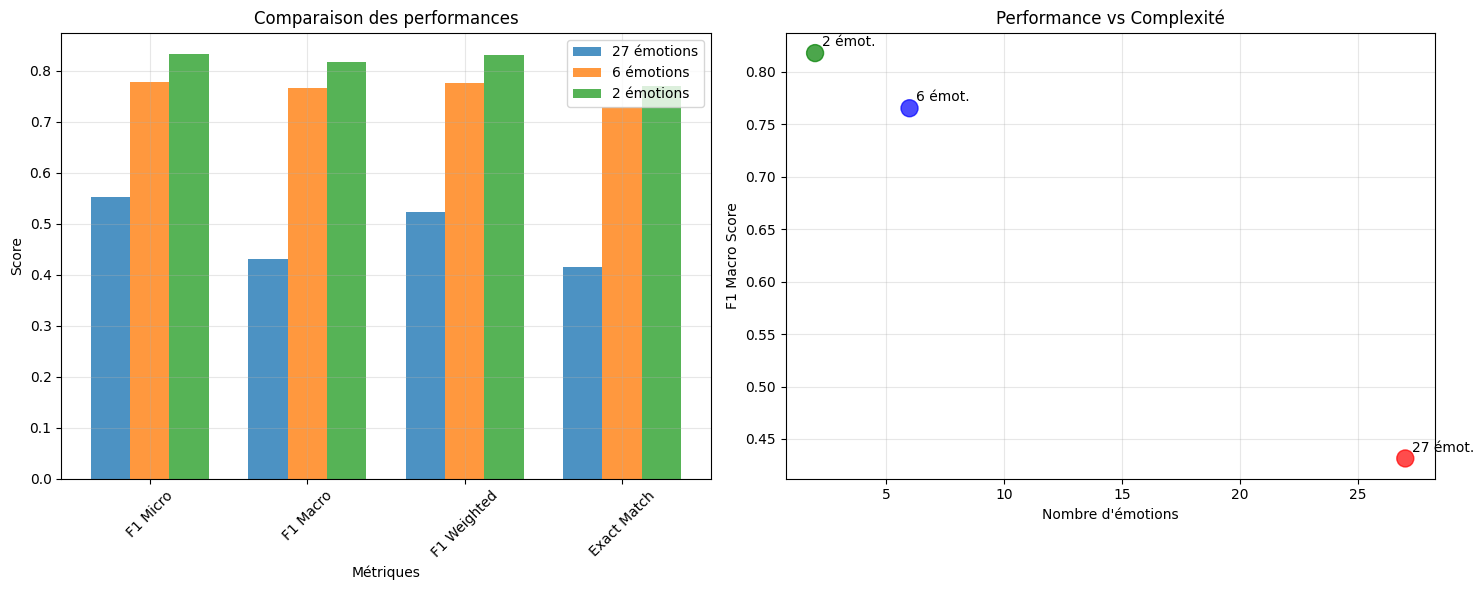

In [ ]:
df_comparison = compare_models(test_results_27, test_results_6, test_results_2)